In [3]:
# importing the necessary packages and libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from numpy import linalg as LA

## 1 - Simulation

<b> 1.1 </b>

In [4]:
def generate_x(N):

    '''
    This function generates a multivariate matrix x with N observations

    Parameters
    ----------
    N: no. of observations

    Returns
    -------
    x: multivariate matrix 

    '''

    mu = np.array([5,2,1])
    covm = np.array([[1, 0.4, 0], [0.4, 1.5, 0], [0, 0, 2]])

    np.random.seed(102030)

    x = np.random.multivariate_normal(mu, covm, size = N)

    return x

### 1.2 ~ Simulate N = 20 using distribution from generate_x(20)

In [5]:
N = 20
x = generate_x(N)

# store original x values for later use
x_org = x
print(f"We have generated a dataset 'x' with {x.shape[0]} observations")

We have generated a dataset 'x' with 20 observations


In [6]:
x

array([[ 4.36374315,  2.20768854,  4.7923386 ],
       [ 4.78005043,  1.95944174,  0.19442543],
       [ 4.94450806,  2.31057042,  0.68006288],
       [ 5.84325979,  3.76992373,  0.20265144],
       [ 5.88522661,  1.6214196 ,  2.43798989],
       [ 5.92188098,  2.9105985 ,  1.62120249],
       [ 4.57082527,  1.81443434,  0.91044842],
       [ 5.06325986,  3.4012444 , -1.03317302],
       [ 3.5198066 ,  0.22396532,  1.29333433],
       [ 4.11901961,  2.97843056,  0.89976909],
       [ 5.22283911,  3.17868247,  2.84084466],
       [ 5.57565248,  1.4708037 ,  1.02155662],
       [ 2.92542633,  1.54639316,  0.96832803],
       [ 5.45094481,  1.06150187, -1.42269635],
       [ 4.85000315,  2.15154362,  1.94078026],
       [ 5.75498172,  1.16128924,  2.58317303],
       [ 3.60739389,  1.34093718,  0.05871876],
       [ 2.42002217,  0.17975934,  0.05491707],
       [ 5.45026833,  1.28869353, -0.3032869 ],
       [ 5.74967708,  1.81090254, -0.97248063]])

## 2 - OLS, Bootstrapping, and Multicollinearity

According to the instructions, the true model is given by 
\begin{equation}
y=\alpha + \beta_1 x_1 + \beta_2 x_2+ϵ. 
\end{equation}

where $\alpha = 10, \beta_1 = 1$ and $\beta_2 = 5$

As we see above, our $x$ matrix contains $x_1, x_2$ and $x_3$ and no $intercept$ yet. Since the true model $DGP$ is given by only $x_1$ and $x_2$ we will need to drop the 3rd column $x_3$ and add an $intercept$ in order to get the true values of y which afterwards we will use to fit a OLS of our matrix $x$ including the $x_3$ column. 

In [7]:
def slice_x(x):
    '''
    This function drops the 3rd column of x and adds an intercept to the dataset 

    Parameters
    -----------
    x: matrix

    Returns
    -------
    x: matrix with 2 columns and an intercept
    '''
    
    x = x[:,:2]

    x = sm.add_constant(x)
    
    return(x)

In [8]:
x_true = slice_x(x)
x_true # we can see constant column is now added

array([[1.        , 4.36374315, 2.20768854],
       [1.        , 4.78005043, 1.95944174],
       [1.        , 4.94450806, 2.31057042],
       [1.        , 5.84325979, 3.76992373],
       [1.        , 5.88522661, 1.6214196 ],
       [1.        , 5.92188098, 2.9105985 ],
       [1.        , 4.57082527, 1.81443434],
       [1.        , 5.06325986, 3.4012444 ],
       [1.        , 3.5198066 , 0.22396532],
       [1.        , 4.11901961, 2.97843056],
       [1.        , 5.22283911, 3.17868247],
       [1.        , 5.57565248, 1.4708037 ],
       [1.        , 2.92542633, 1.54639316],
       [1.        , 5.45094481, 1.06150187],
       [1.        , 4.85000315, 2.15154362],
       [1.        , 5.75498172, 1.16128924],
       [1.        , 3.60739389, 1.34093718],
       [1.        , 2.42002217, 0.17975934],
       [1.        , 5.45026833, 1.28869353],
       [1.        , 5.74967708, 1.81090254]])

### 2.1

Now we will generate $y$ using the $x_1$ and $x_2$ from above.

In [9]:
def generate_y(x, N, *coef_params):

    '''
    This function takes a dataset x and "N" number of observations and generates a y array with given parameters

    Parameters
    ----------
    x: multivariate matrix
    N: number of observations
    *coef_params: alpha, betas

    Returns
    -------
    
    y: vector 

    '''

    np.random.seed(102030)

    e = np.random.normal(0, 1, N)

    betas = np.array([*coef_params])

    y = np.dot(x,betas) + e

    return y

In [10]:
alpha_true = 10
beta1_true = 1
beta2_true = 5
y = generate_y(x_true, N, alpha_true, beta1_true, beta2_true)

In [11]:
print(f"The true values for y using equation two are below: \n {y}")

The true values for y using equation two are below: 
 [28.0837742  24.48063489 25.75244067 34.1232512  23.88402891 30.27909793
 23.41676728 32.25600022 14.41396184 28.44736185 32.60758873 22.79313659
 21.67420452 20.83314731 26.69337737 22.00068443 21.25965511 13.73242251
 21.83041346 24.52193686]


In [12]:
sm.OLS(y,x_true).fit().summary(); # we checked it although it wasnt required

### 2.2

As mentioned above, now we will use $y$ and the original dataset $x$ which includes $x_1$, $x_2$ and $x_3$ and add an intercept to it in order to fit an OLS regression.  

In [13]:
# adding intercept to the dataset  
x = sm.add_constant(x)

# fit the regression
fit = sm.OLS(y,x).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     410.6
Date:                Thu, 17 Mar 2022   Prob (F-statistic):           2.43e-15
Time:                        18:01:06   Log-Likelihood:                -18.023
No. Observations:                  20   AIC:                             44.05
Df Residuals:                      16   BIC:                             48.03
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1132      0.736     15.100      0.000       9.553      12.673
x1             0.7362      0.166      4.424      0.000       0.383       1.089
x2             5.0497      0.176     28.652      0.000       4.676       5.423
x3             0.3345      0.103      3.253      0.005       0.117       0.553
==============================================================================
Omnibus:                        2.272   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.321   Jarque-Bera (JB):                1.101
Skew:                          -0.081   Prob(JB):                        0.577
Kurtosis:                       1.862   Cond. No.                         27.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2.3

In [14]:
b_res = fit.params    # intercept + betas
ci_s = fit.conf_int() # confidence intervals
beta_ci = list(zip(b_res,ci_s))[1:]
i = 0

for beta, ci in beta_ci:
    i += 1
    print(f"The following Beta{str(i)} parameter has value {round(beta,4)} and confidence intervals {ci}")

The following Beta1 parameter has value 0.7362 and confidence intervals [0.3834675  1.08895941]
The following Beta2 parameter has value 5.0497 and confidence intervals [4.67610995 5.42335824]
The following Beta3 parameter has value 0.3345 and confidence intervals [0.11652823 0.55254751]


### 2.4 - Boostraping - Simulating a bootstrap with 1000 simulations

A $bootstrap$ dataset is a dataset which we generate by resampling the original dataset with replacement. Therefore, as per the definition, we have generated $x_{bootstrap_{dataset}}$, $y_{bootstrap_{dataset}}$ which contain 1000 different datasets generated from using $bootstrap$ method: sampling with replacement for $B$ simulations

In [15]:
def bootstrap(B, N, y, x):

    '''
    This function returns a "B" bootstrapped dataset for x and y using along with the beta values for the bootstrapped dataset
    
    Parameters
    ----------
    B: (int) number of simulations 
    N: sample size for the original dataset
    y: dependent values
    x: independet values

    Returns
    --------
    global:
        x_bootstrap_dataset: 1000 bootstrapped x datasets 
        y_bootstrap_dataset: 1000 bootstrapped y datasets 

    bb_bootstrapped: intercept + beta coefficients for bootstrapped values
    '''

    # creating lists to store B = 1000 bootstrap datasets
    
    global x_bootstrap_dataset
    x_bootstrap_dataset = []
    
    global y_bootstrap_dataset
    y_bootstrap_dataset = []

    # creating lists to store the bootstrap betas 
    bb_bootstrapped = [[] for i in range(x.shape[1])]      



    # repeat experiment B = 1000 times to generate B = 1000 bootstrap datasets

    for b in range(B):    

        # choose a random index 
        # use x.shape[0] to get random value from rows instead of columns which can mess up beta estimations
        random_index = np.random.choice(x.shape[0], size=N)  
        
        # selecting random indexes from the given dataset
        y_boot   = y[random_index]    
        x_boot   = x[random_index]
        
        # add each randomly indexed values to the bootstrapped lists defined above
        
        # 2.4 - now we will add each element to the bootstraped list above which after B = 1000 iterations will
        # include 1000 bootstrapped datasets 

        x_bootstrap_dataset.append(x_boot)
        y_bootstrap_dataset.append(y_boot)

        # 2.5 below

        # fixing y_boot so it has shape [N,1] instead of [N,] in order to allow for dot product.
         
        y_boot = y_boot[:,None]  # we only add for y_boot since x_boot has shape [20,4] whereas y_boot has [1,]
        
        # iterate for each column vector 
        for i in range(x_boot.shape[1]):
            b = np.dot(np.linalg.inv(np.dot(x_boot.T,x_boot)),np.dot(x_boot.T,y_boot))[i][0]
            bb_bootstrapped[i].append(b)

    return(bb_bootstrapped)
    

In [16]:
# Below are the 1000 simulated datasets
B = 1000
bootstrap(B, N, y, x)
x_bootstrap_dataset;
y_bootstrap_dataset;
print(f"We have generated {len(x_bootstrap_dataset)} bootstrap samples. Each matrix ''x_bootstrap_dataset'' contains {len(x_bootstrap_dataset[0])} observations!")
print()

We have generated 1000 bootstrap samples. Each matrix ''x_bootstrap_dataset'' contains 20 observations!



### 2.5 

Below are $\beta s$ generated using bootstrap method. 

In [17]:
alpha, beta1, beta2, beta3 = bootstrap(B, 20, y, x)

### 2.6 - Plot Histograms of betas

In [18]:
def plot_betas(beta_boot, number):

    '''
    This function takes the Beta values and returns a histogram of the Beta dsitribution, showing the mean and the median of the Beta distribution

    Parameters
    ----------
    beta_boot: Beta values
    number: string of number to identify which Beta is represented by the dsitribution

    Returns: 

    A histogram showing the distribution of the betas together with the meand and the median
    '''
    number = str(number)

    median = np.median(beta_boot)
    mean = np.mean(beta_boot)
    
    plt.subplots(1, figsize=(6,4))
    sns.histplot(beta_boot, color = 'hotpink', edgecolor ='aqua') ; plt.title(r'$\beta_{0}(bootstrapped)$'.format(number))
    plt.axvline(mean, color = 'yellow', label = 'mean of the distribution')
    plt.axvline(median, color='indigo', label = 'median of the distribution')

    plt.legend()
    plt.show()

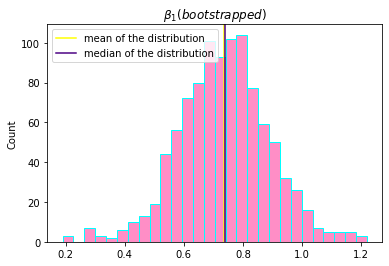

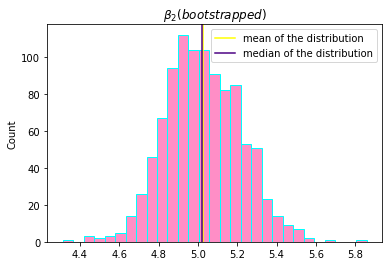

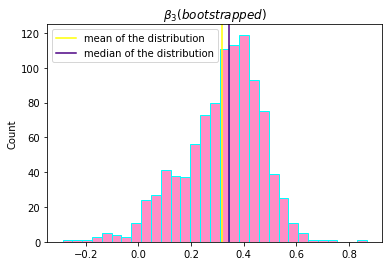

In [19]:
# Plotting beta for beta1, beta2 and beta3
plot_betas(beta1, 1)
plot_betas(beta2, 2)
plot_betas(beta3, 3)

### 2.7

In [20]:
# redoing 1.1 for N = 1000 observations
N = 1000
x_1000 = generate_x(N)
print(f"We have generated a dataset 'x' with {x_1000.shape[0]} observations")

We have generated a dataset 'x' with 1000 observations


### 2.8

2.8 - 2.4 & 2.5

In order to simulate a 1000 bootstrap dataset with $N = 1000$ observations, we first need to slice $x_{1000}$ in order to simulate $y_{true}$ for when x has 1000 observations since the $y$ we already have contains only 20 observations. Since the $y_{true}$ only includes $x_1$ and $x_2$, we will again use $slice_x()$ to drop column for $x_3$ and add intercept to get the true values for $y_{true}$ which in this case is $y_{1000}$.

In [21]:
# droping x_3 and adding intercept to get true values for y_1000
x_1000_true = slice_x(x_1000)

# adding intercept to original dataset to run bootstrap afterwards
x_1000 = sm.add_constant(x_1000)

# get true values for y_1000 
y_1000 = generate_y(x_1000_true, N, alpha_true, beta1_true, beta2_true)

In [22]:
# 2.5 repeated betas are now these that we get from the line below
alpha_1000, beta1_1000, beta2_1000, beta3_1000 = bootstrap(B, N, y_1000, x_1000)

# 2.4 repeated bootstrap datasets are now included here and the print() provides more details
x_bootstrap_dataset;
y_bootstrap_dataset;

print(f"We have generated {len(x_bootstrap_dataset)} bootstrap samples. Each matrix ''x_bootstrap_dataset'' contains {len(x_bootstrap_dataset[0])} observations!")


We have generated 1000 bootstrap samples. Each matrix ''x_bootstrap_dataset'' contains 1000 observations!


You can open x_bootstrap_dataset for checking but its output was too large to include here since 1000 x 1000 values

2.8 - 2.6

Below are the $\beta$ distributions for the $bootstrapped$ samples when $N = 1000$

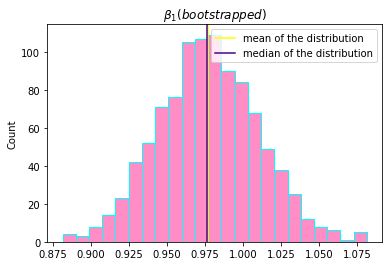

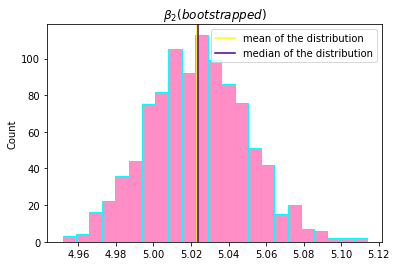

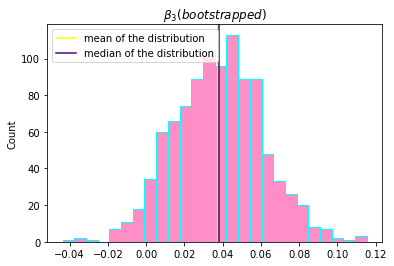

In [23]:
plot_betas(beta1_1000, 1)
plot_betas(beta2_1000, 2)
plot_betas(beta3_1000, 3)

### Comment briefly on the difference between histograms you obtain now and on 2.6

The difference in $\beta_s$ from 2.6 and 2.8-2.6 is that medians for $\beta_1$ and $\beta_2$ are closer to the true when N=1000 values and this is because of the law of large numbers. There is also quite a big difference between median of $\beta_3$ since the true model is given by just beta_1 and $\beta_2$, when the number of observations is much larger, the $\beta_3$ will shrink while $\beta_1$ and $\beta_2$ approach their true values.

### 2.9

In the following we will drop the current column $x_3$ and add a new column as a function os the first two columns. To do this we will use $x$ from 1.1 and the function slice_x(). Afterwards we will add a new column $x_3$ as a function of the first two columns.

In [24]:
x_mc = slice_x(x_org)

In [25]:
# adding third col as a a function of x_1 and x_2 but now we use [1] and [2] since index [0] contains intercept
new_x = (x_mc.T[1] + x_mc.T[2])/2

# create a vector with shape [N,1]
new_x = new_x[:,None]

# adding the column to the dataset
newest_x = np.hstack((x_mc, new_x)) # adds a new column to x that is a combo of two previous ones
reg_x = sm.add_constant(newest_x) 

In [26]:
sm.OLS(y, reg_x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     390.5
Date:                Thu, 17 Mar 2022   Prob (F-statistic):           6.20e-15
Time:                        18:01:14   Log-Likelihood:                -23.099
No. Observations:                  20   AIC:                             52.20
Df Residuals:                      17   BIC:                             55.19
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4006      0.914     12.478      0.000       9.473      13.328
x1            -0.2526      0.192     -1.313      0.207      -0.658       0.153
x2             4.1368      0.201     20.628      0.000       3.714       4.560
x3             1.9421      0.075     25.865      0.000       1.784       2.101
==============================================================================
Omnibus:                        9.839   Durbin-Watson:                   1.478
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                7.213
Skew:                           1.206   Prob(JB):                       0.0271
Kurtosis:                       4.685   Cond. No.                     5.60e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.61e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<br>

We notice that we get 2 warnings in this case. The 2nd warning highlights <i> strong <b> multicollinearity </b> problems </i>.
This is because our reg_x is column-rank efficient, in other words: one column $x_3$ is a linear combination of other columns ($x_1,x_2$).
<br>
Note: in our case only one column is a linear combination of others, but by definition, there could be more than one. 

We are getting a huge p-value for $x_1$ which is insignificant at 5%, 10% and 20% level. 

# 2.10

In order to deal with multicollinearity we have a few alternatives: <br>
1. Delete variable/s <br>
-> It is always very sensitive what variable we want to delete. In this case it could make sense to drop $x_1$ due to the high p_value and it would also remove the multicollinearity problem. But since we know that $x_3$ is a linear combination of others, it would be smartest to drop that.<br><br>
2. Make pair plots to detect any linearity
3. Regularization

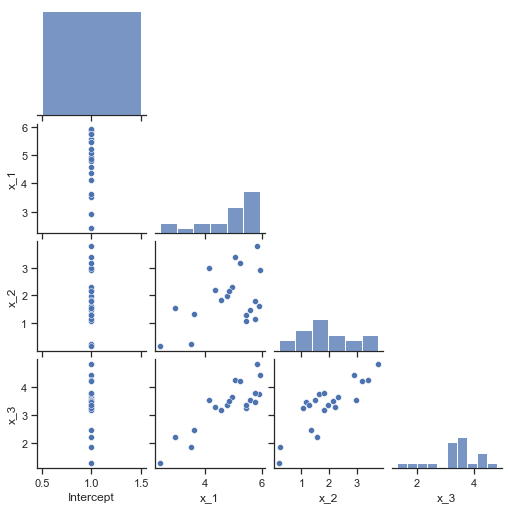

In [27]:
# making a pairplot to see if there is any perfect correlation
interc = reg_x.T[0]
x_1 = reg_x.T[1]
x_2 = reg_x.T[2]
x_3 = reg_x.T[3]

pairplot = pd.DataFrame({"Intercept": interc, "x_1": x_1, "x_2": x_2, "x_3": x_3})

sns.set_theme(style = "ticks")
g = sns.pairplot(pairplot, corner = True)
g.fig.set_size_inches(7,7)

We see that both relationships $x_3$ has with $x_1$ and $x_2$ is falling into a straight line. Even though it is not 100% conclusive, it gives us a lot of insight to visually see such a relationship.

What we could do to solve this is use regularization methods where we would minimize the penalized square error. Two very famous methods to do this are Ridge and Lasso or both at once. This methods use a penalty term $\lambda C$($\Beta$). Since one of the main issues with multicollinearity is that variance is usually very high and $X^TX$ in non-invertible. Therefore by adding a penalty factor where $\lambda$ > 0 will lead to reduced variance and make $X^TX$ invertible

# 3 - Timeseries and Model Selection

In [28]:
# loading the dataset 
nile = sm.datasets.get_rdataset("Nile").data

# take a short look at the data
nile.head();

### 3.1

We see that the annual flow is represented by $value$ hence we use that as dependent variable to plot the data

Text(0, 0.5, 'Annual Flow')

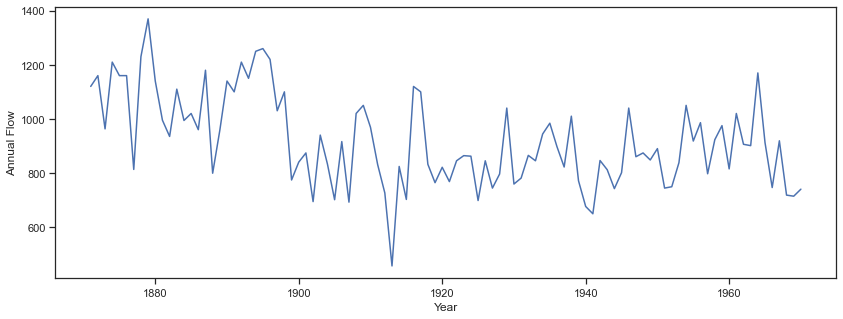

In [29]:
# plotting the annual flow
x_data = nile["time"]
y_data = nile["value"]
fig, ax  = plt.subplots(figsize=(14,5))
ax.plot(x_data, y_data)
ax.set_xlabel("Year")
ax.set_ylabel("Annual Flow")


### 3.2 - Plotting ACF & PACF

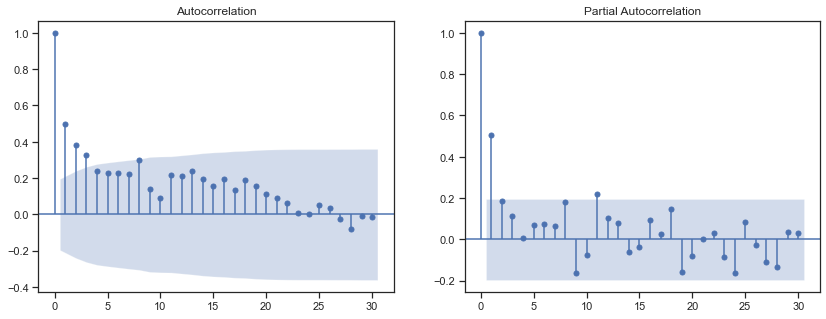

In [30]:
# define no. of lags
lags = 30

fig, axs = plt.subplots(1,2,figsize=(14,5))
plot_acf(y_data, lags = lags, ax=axs[0])
plot_pacf(y_data, lags = lags, ax=axs[1])
plt.show()

### 3.3

By looking at 3.1, we see that there is a lot of random movements in the annual flow suggesting that it is unpredictable. Additionally, we the fact that it is unpredictable is also seen by looking at $PACF$ which suggests shows significant lags only for lag 1, indicating that we have an AutoRegressive process of order 1. Therefore we can say that the annual flow of the river is relatively unpredictable. 

### 3.4

As instructed in the task by simply looking diagrams from 3.2, we choose the model with $p = 1$ $lag$. <br> The reason is that $PACF$ cuts off after $lag_1$. However, we will still test the model performance with up to 3 lags since that is the number of significant lags in $ACF$ graph

### 3.5

In [31]:
def orders(n):
    '''
    This function takes an integer parameters n, and returns a list of tuples specifying "n" number of lags
    
    Parameters
    ----------
    n: number of lags we want to include 

    Returns:
    List of tuples containing n lags

    '''
    # define list to store tuples
    orders = []
    
    for i in range(n):
        order = (i+1, 0, 0)
        orders.append(order)
        
    return(orders)

In [32]:
# As mentioned above, we will test for 3 lags 
# splitting y_data for training and testing purposes
train = 95
y_te = y_data.T[train:] # last 5 years for testing
y_tr = y_data.T[:train]

orders_three = orders(3)

# loop through the 3 models with different lags
for i,order in enumerate(orders_three):   
  # define and fit AR model
    model = ARIMA(y_tr, order=order).fit()

   # Forecast
    horizon = y_te.shape[0]
    y_hat = model.forecast(horizon)
  
   # get the metrics
    mse = np.mean((y_hat - y_te)**2)
    rmse = np.mean((y_hat - y_te)**2)**0.5

    print(f"Model with {i+1} lag has rmse {round(rmse,3)}")

Model with 1 lag has rmse 175.093
Model with 2 lag has rmse 198.205
Model with 3 lag has rmse 195.567


As the PACF graph indicated as well, model with 1 lag performs the best.

### 3.6 - Test for AR proccesses of up to order 5 and create a table

In [33]:
# create lists to store the metrics
store_rmse = []
store_aic = []

# define number of lags to loop through
orders_five = orders(5)

# loop through the 5 diff models
for i, order in enumerate(orders_five):
  # define and fit AR model
  model = ARIMA(y_tr, order=order).fit()

  # Forecast
  horizon = y_te.shape[0]
  y_hat = model.forecast(horizon)
  
  # get the metrics
  rmse = np.mean((y_hat - y_te)**2) ** 0.5
  aic = model.aic
  # round up to 3
  rmse, aic = round(rmse, 3), round(aic, 3)
  
  # store the metrics  
  store_aic.append(aic)
  store_rmse.append(rmse)

In [34]:
# creating a dataframe to present the results in a table
AR = []
for i, lago in enumerate(orders_five):

    ai = "AR" + "(" + str(i+1) + ")"

    AR.append(ai)

table = pd.DataFrame({"Model": AR, "rmse": store_rmse, "AIC": store_aic}, index = None)
table.index = [''] * len(table)
table

,Model,rmse,AIC
,AR(1),175.093,1222.392
,AR(2),198.205,1220.108
,AR(3),195.567,1221.159
,AR(4),201.158,1222.975
,AR(5),207.668,1223.778


### 3.7 - Choosing a winner based on results

We want to choose the model with the lowest $rmse$ or $AIC$, therefore we will select the model which includes the lowest score.

In [72]:
# selecting winner model with lowest score

winner_rmse = table[table["rmse"] == min(table["rmse"])]
winner_aic = table[table["AIC"] == min(table["AIC"])]
print("The winner model according to rmse is {0} with rmse: {1}".format(winner_rmse.values[0][0], winner_rmse.values[0][1]))
print("The winner model according to AIC is {0} with AIC: {1}".format(winner_aic.values[0][0], winner_aic.values[0][2]))

The winner model according to rmse is AR(1) with rmse: 175.093
The winner model according to AIC is AR(2) with AIC: 1220.108


# 4 -  Classification, K-fold Cross-Validation and PCA

In this task we have worked with logistic regression since we have a binary response in the target column.

In [35]:
# read the data
sant = pd.read_csv("santander_dataset.csv")

# Look at the data breifly to identify the binary variable
sant.head();

In [36]:
y_log = sant["target"]  # binary response

# getting the dataset with only independent variables
x_log = sant[sant.columns.drop(['ID_code', 'target'])]

# adding an intercept as suggested in the instructions
x_logc = sm.add_constant(x_log)

# making sure intercept is added
x_logc.shape;

### 4.1

In [37]:
# splitting data 70 training and 30 testing
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1234)

# alternatively we could use: from sklearn.model.selection import train_test_split

for train_index, test_index in sss.split(x_logc, y_log):
    x_tr, x_te = x_logc.iloc[train_index], x_logc.iloc[test_index]
    y_tr, y_te = y_log.iloc[train_index], y_log.iloc[test_index]

In [38]:
# fitting a logistic regression
log_regression = sm.Logit(y_tr, x_tr)
fit_log = log_regression.fit(disp=0)

# getting false positive, true positive rate and thresholds
fpr,tpr, threshold = metrics.roc_curve(y_te,fit_log.predict(x_te))

mean_fpr = np.linspace(0,1,100)
roc_auc = metrics.auc(fpr, tpr)

print(f'ROC_AUC_score from sm.Logit: {roc_auc}')

ROC_AUC_score from sm.Logit: 0.852970132479844


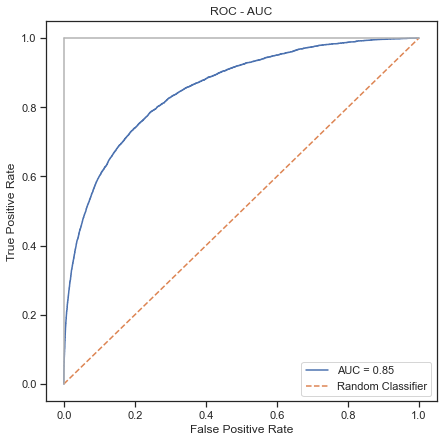

In [39]:
# plotting the AUC curve
plt.subplots(1, figsize=(7,7))
plt.title('ROC - AUC')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], ls="--", label="Random Classifier")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

We want the blue curve to be as close to the top left corner as possible suggesting that 100% of the predictions are correct. Currently with an $AUC$ score of 0.85, we are still getting very good predictions.

### 4.2 - Run 5~fold CV & report avg.AUC and std.AUC

In the example above we have only done 1 fold cross validation with 70-30. Now we will do 5 fold Cross Validation.

Credits for SMWrapper: https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible

In [40]:
from sklearn.base import BaseEstimator, RegressorMixin
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit(disp=0)
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [41]:
# run 5 fold cross validation since the example above is only one iteration with 70-30
auc_report = []
std_report = []
folds = 5

kfolds = KFold(n_splits = folds, shuffle=True)
  
# se the cross_val_score function to fit K models
# SMWrapper adds intercept so we are using x_log instead of x_logc

scores = cross_val_score(SMWrapper(sm.Logit), x_log, y_log, cv=kfolds,\
                           scoring='roc_auc')

# store the scores
auc_report.append(np.mean(scores))
std_report.append(np.std(scores))

print(f"5 fold CV has an avg. AUC {round(np.mean(scores), 5)} and std. AUC {round(np.std(scores), 5)}")

5 fold CV has an avg. AUC 0.85942 and std. AUC 0.00312


Now we want to reduce dimensionality while keeping as much of the data as possible. Since eigenvectors are vectors which when transformed change length but not direction, by sorting the eigenvectors of the covariance matrix in a descending order would mean that the first eigenvectors will represent the largest spread of the data. Therefore in the following code we will want to keep n first eigenvectors in order to account for the the most spread of the data we can by keeping only n features

In [42]:
names = ["Avg. AUC", "Std. AUC"]
orig_dim = [auc_report[0],std_report[0]]
table_results = pd.DataFrame({"Score": names, "Model Performance": orig_dim})
table_results.index = [''] * len(table_results)
table_results

,Score,Model Performance
,Avg. AUC,0.859425
,Std. AUC,0.003117


### 4.3

In [43]:
# define number of factors
n = (20, 50, 100)

# Define list to store the rows with n-first eigenvalues
pca = [ [] for i in range(len(n))]

# Mean of the x data
x_log_mean = x_log.mean(axis = 0)

# centering the data 
x_log -= x_log_mean  

# covariance matrix
cov_x = np.cov(x_log.T)

# get eigenvectors (v) and eigenvalues (w)
w, v = LA.eig(cov_x)

# get idx in descending order based on w
inx = w.argsort()[::-1]

# sort eig.vectors and eig.values
w, v = w[inx], v[:, inx]

i = 0

for k in n:
    
    # get the first n eig.vectors 
    v_first = v[:, :k]

    # getting eigenvalues to test variability

    pp = x_log.dot(v_first)
    pca[i].append(pp)


    i += 1

In [44]:
# We have to turn the pca elements into arrays and fix their shape since we stored the pca results in a list above

pca_matrix = [np.asarray(pca[0]), np.asarray(pca[1]), np.asarray(pca[2])]
i = 0
for array in pca_matrix:

    pca_matrix[i] = np.reshape(array, (array.shape[1], array.shape[2]))

    i += 1

Apply transformation to the whole dataset: below is each transformation, we have cut the output due to it being too big

In [45]:
# dataset with 20, 50, 100 factors after PCA 
pca_20, pca_50, pca_100 = pca_matrix

pca_20;
pca_50;
pca_100;

We know that the formula to measure the total variability captured by each of the PCA transformations. Since we are ordering eigenvalues and eigenvectors in descending order, the variability captures by first "n" eigenvalues is determined by  
$$
\frac{\lambda_{j=1}^m}{\sum_{k=1}^p \lambda_k}
$$ 

Therefore, below we have written a short code that will calculate the total variability based on this formula.

In [46]:
# testing how much variability we are capturing using eigenvalues

total_sum_eig = np.sum(w)

for i in n:

    variance = (np.sum(w[:i]/total_sum_eig)) * 100

    print(f"With {i} features we can account for {round(variance,2)}% of the total variability from original dataset")

With 20 features we can account for 43.9% of the total variability from original dataset
With 50 features we can account for 72.88% of the total variability from original dataset
With 100 features we can account for 92.75% of the total variability from original dataset


Below we have the dataset after we have applied the transformations to reduce dimensionality to 20, 50, and 100 factors

### 4.4 

<b> 5~fold CV for each PCA transformation </b>

In [47]:
# iterating through each PCA transformation

for pca in pca_matrix:

    folds = 5

    kfolds = KFold(n_splits = folds, shuffle=True)
  
    scores = cross_val_score(SMWrapper(sm.Logit), pca, y_log, cv=kfolds,\
                           scoring='roc_auc')

    print('5 fold CV for dataset with dimenasionality reduced to {0} factors has average AUC {1:.6f} and Std. {2:.4f}'.format(pca.shape[1],np.mean(scores),np.std(scores)))

    auc_report.append(np.mean(scores))
    std_report.append(np.std(scores))  

5 fold CV for dataset with dimenasionality reduced to 20 factors has average AUC 0.610339 and Std. 0.0051
5 fold CV for dataset with dimenasionality reduced to 50 factors has average AUC 0.707247 and Std. 0.0044
5 fold CV for dataset with dimenasionality reduced to 100 factors has average AUC 0.776169 and Std. 0.0021


In [48]:
pca_20 = [auc_report[1], std_report[1]]
pca_50 = [auc_report[2], std_report[2]]
pca_100 = [auc_report[3], std_report[3]]

table_results = pd.DataFrame({"Score": names, "Orig. dim.": orig_dim, "PCA-20": pca_20, "PCA-50": pca_50, "PCA-100": pca_100})
table_results.index = [''] * len(table_results)
table_results

,Score,Orig. dim.,PCA-20,PCA-50,PCA-100
,Avg. AUC,0.859425,0.610339,0.707247,0.776169
,Std. AUC,0.003117,0.005121,0.004410,0.002058


### 4.5 Choosing model to be used by the bank

In 4.1 we trained the model using 70% of the data for training and 30% for testing. In 4.2, we used a 5 fold CV, where we iterate five times and split the dataset into 5 folds, 4 which are used for training and 1 for testing, until each has been used for testing once. In 4.4 we reduce the dimensionality of the data while accounting for the most variability we can given the number of factors (20,50,100). Afterwards we are repeating 4.2 for each of them. To choose the best model we will look at three things: AUC score, variability, and model complexity. Hence, we decided that the bank should use the model PCA_50 because at 50 fetures we still keep more than 70% of the variability but reduce the complexity by 75%. In addition, PCA_50 has an AUC score of 0.707, only 0.07 less than PCA_100 which includes over 90% variability but had twice as many features. 

In [49]:
!jupyter nbconvert --to HTML midterm.ipynb

[NbConvertApp] Converting notebook midterm.ipynb to HTML
[NbConvertApp] Writing 917681 bytes to midterm.html
